In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from astropy.time import Time, TimezoneInfo
from statsmodels.tsa.stattools import adfuller

from lsst.sitcom import vandv
from lsst.ts.idl.enums import MTM1M3

from lsst.summit.utils.tmaUtils import TMAEventMaker, TMAState
from lsst.summit.utils.efdUtils import getEfdData, makeEfdClient
from lsst_efd_client import EfdClient
from tqdm import tqdm
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
import os
os.getcwd()

'/home/psferguson/repos/psferguson_sitcom/projects/tma/notebooks'

In [75]:
slew_summary_frame=pd.read_csv("../data/slew_summaries/slew_summary_frame_20230628.csv")
slew_summary_frame=slew_summary_frame.dropna(axis=0, subset=["motion_state","balanceForcesApplied"])

In [76]:
np.unique(slew_summary_frame["balanceForcesApplied"])

array([False, True], dtype=object)

In [77]:
sel.sum()

1068

In [81]:

violin_data=[slew_summary_frame["abs_max_hp_force"][(slew_summary_frame["motion_state"]==i) & sel].values for i in np.unique(slew_summary_frame["motion_state"])]

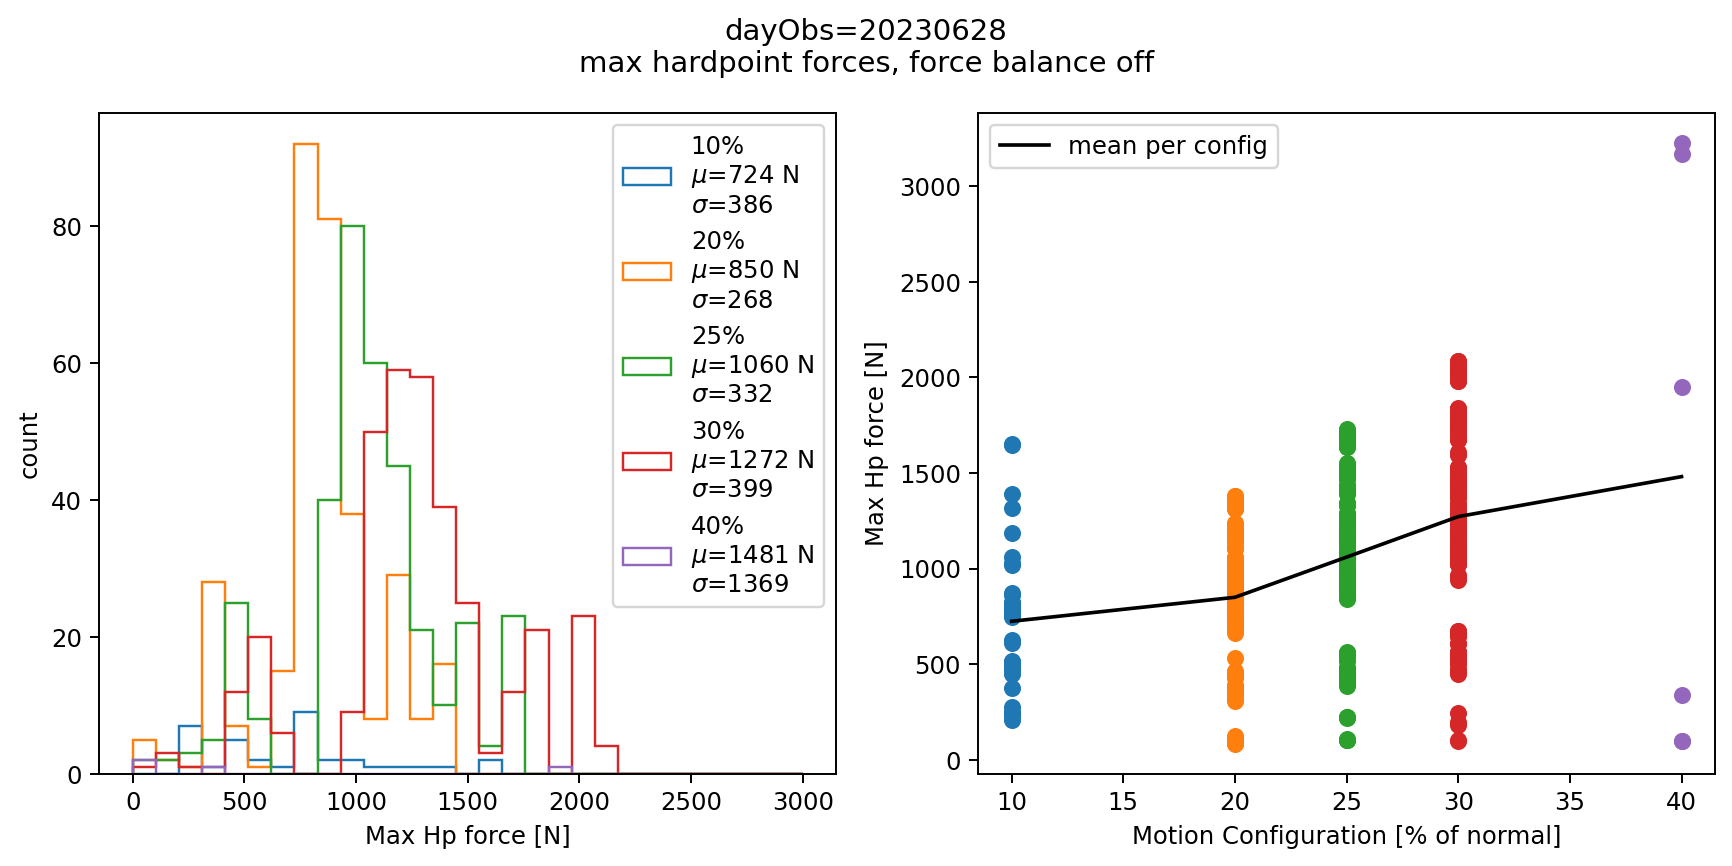

In [124]:
sel=(slew_summary_frame["balanceForcesApplied"] == False)
fig, axs=plt.subplots(1,2,dpi=175, figsize=(10,5))
med_vals=[]
for i in np.unique(slew_summary_frame["motion_state"]):
    ax=axs[0]
    subset=slew_summary_frame["abs_max_hp_force"][(slew_summary_frame["motion_state"]==i) & sel].values
    ax.hist(subset, bins=np.linspace(0,3000,30), histtype="step", label=f"{i:0.0f}%\n$\mu$={np.mean(subset):0.0f} N\n$\sigma$={np.std(subset):0.0f}")
    ax2=axs[1]
    ax2.scatter(np.ones_like(subset) * i,subset)
    med_vals.append(np.mean(subset))
ax2.plot(np.unique(slew_summary_frame["motion_state"]), med_vals, c="k", label="mean per config")
ax.legend()
ax2.legend()
ax.set_xlabel("Max Hp force [N]")
ax.set_ylabel("count")
ax2.set_xlabel("Motion Configuration [% of normal]")
ax2.set_ylabel("Max Hp force [N]")
plt.suptitle("dayObs=20230628\nmax hardpoint forces, force balance off")
plt.tight_layout()

Text(0.5, 0, 'motion configuration')

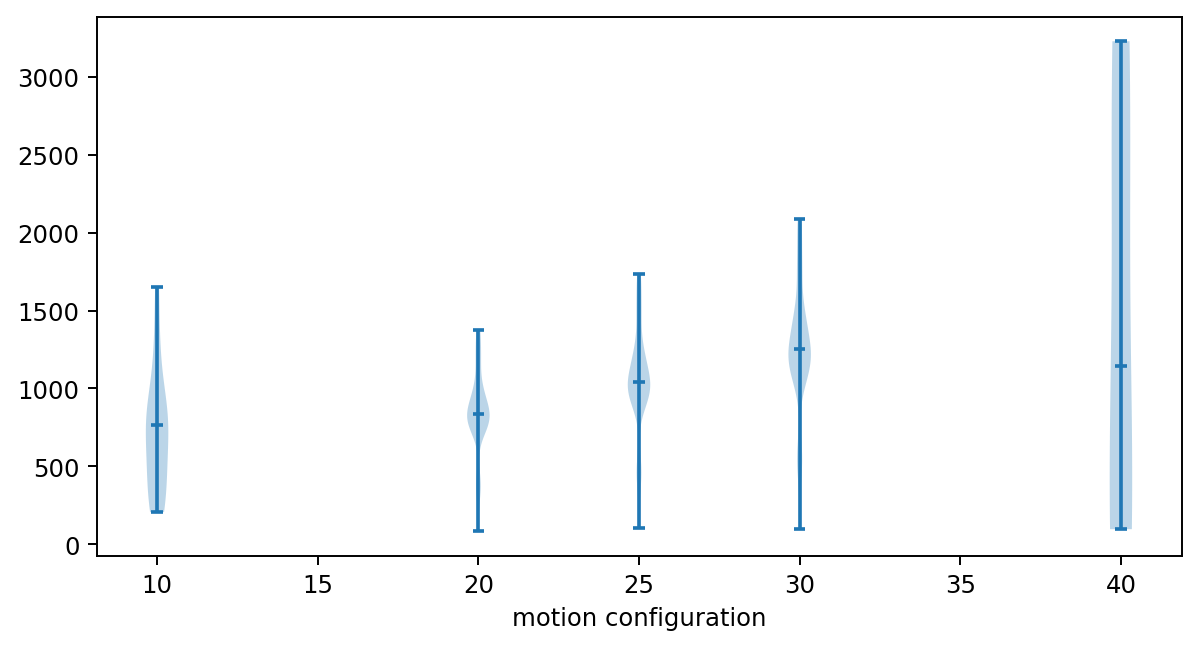

In [92]:
fig, ax=plt.subplots(dpi=175, figsize=(8,4))
_=ax.violinplot(violin_data, 
               positions=np.unique(slew_summary_frame["motion_state"]),
               showmedians=True, showextrema=True, widths=0.7, )
# plt.scatter(slew_summary_frame["motion_s1tate"][sel], 
#             slew_summary_frame["abs_max_hp_force"][sel],
#             s=0.2, c="k")
ax.set_xlabel("motion configuration")

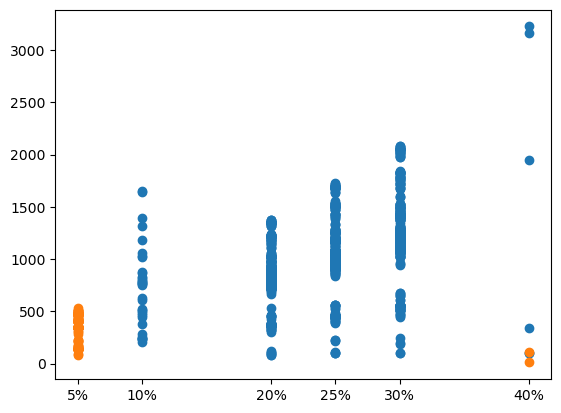

In [71]:
sel=(slew_summary_frame["balanceForcesApplied"] == False)
plt.scatter(slew_summary_frame["motion_state"][sel], slew_summary_frame["abs_max_hp_force"][sel])
plt.scatter(slew_summary_frame["motion_state"][~sel], slew_summary_frame["abs_max_hp_force"][~sel])
_=plt.xticks(np.unique(slew_summary_frame["motion_state"]), labels=[f"{i:0.0f}%" for i in np.unique(slew_summary_frame["motion_state"])])


In [ ]:
fig, axs=plt.subplots(3, figsize=(10,5), dpi=175, sharex=True)

ax=axs[0]
ax.set_title("Slews on 23/06/27")
for i in np.unique(slew_summary_frame["motion_state"])[::-1]:
    if np.isnan(i):
        continue
    sel=(slew_summary_frame["motion_state"]==i)
    ax.scatter(Time(slew_summary_frame["begin_slew"][sel], format="unix").datetime,  
               slew_summary_frame["max_torque_el"][sel]/1e3, s=3)
# ax.scatter(Time(slew_summary_frame["begin_slew"][~sel], format="unix").datetime,  
#            slew_summary_frame["max_torque_el"][~sel]/1e3, s=1)

for i in enables["private_sndStamp"]:
    ax.axvline(Time(i, format="unix_tai").utc.datetime, label="enabled", c="tab:green", ls="dashed", alpha=0.2)

for i in disables["private_sndStamp"]:
    ax.axvline(Time(i, format="unix_tai").utc.datetime, label="disabled", c="tab:red", ls="dashed", alpha=0.2)

#ax.set_yscale('log')
ax.set_ylabel("elevation\nmax torque\n[kN M]")
handles, labels = ax.get_legend_handles_labels()
newLabels, newHandles = [], []
for handle, label in zip(handles, labels):
      if label not in newLabels:
        newLabels.append(label)
        newHandles.append(handle)
ax.legend(newHandles, newLabels, title="HardpointCorrections", edgecolor="None")
#ax.legend(ncol=2, loc=2, title="hp balance forces")

ax=axs[1]

for i in enables["private_sndStamp"]:
    ax.axvline(Time(i, format="unix_tai").utc.datetime, c="tab:green", ls="dashed", alpha=0.4)

for i in disables["private_sndStamp"]:
    ax.axvline(Time(i, format="unix_tai").utc.datetime, c="tab:red", ls="dashed", alpha=0.4)



for i in np.unique(slew_summary_frame["motion_state"])[::-1]:
    if np.isnan(i):
        continue
    sel=(slew_summary_frame["motion_state"]==i)
    ax.scatter(Time(slew_summary_frame["begin_slew"][sel], format="unix").datetime,  
               slew_summary_frame["max_torque_az"][sel]/1e3, s=3, label=f"{i}%")

ax.set_ylabel("azimuth\nmax torque\n[kN M]")
ax.set_yticks(np.arange(0,400,100))
handles, labels = ax.get_legend_handles_labels()
lgnd=ax.legend(handles[::-1], labels[::-1],ncol=6, facecolor="White", edgecolor="None")
for i in range(len(lgnd.legendHandles)):
    lgnd.legendHandles[i]._sizes=[10]

lgnd.get_frame().set_alpha(1)
ax=axs[2]

for i in enables["private_sndStamp"]:
    ax.axvline(Time(i, format="unix_tai").utc.datetime, c="tab:green", ls="dashed", alpha=0.4)

for i in disables["private_sndStamp"]:
    ax.axvline(Time(i, format="unix_tai").utc.datetime, c="tab:red", ls="dashed", alpha=0.4)

for i in np.unique(slew_summary_frame["motion_state"])[::-1]:
    if np.isnan(i):
        continue
    sel=(slew_summary_frame["motion_state"]==i)
    ax.scatter(Time(slew_summary_frame["begin_slew"][sel], format="unix").datetime, 
               slew_summary_frame["max_hp_force"][sel], s=4)
#ax.scatter(Time(slew_summary_frame["begin_slew"][~sel], format="unix").datetime, slew_summary_frame["max_hp_force"][~sel], s=1)
# ax.set_yscale('log')
ax.set_xlim(datetime(2023,6,27,21,0), datetime(2023,6,28,12,0))
ax.set_ylabel("max\nhardpoint force\n[N]")



plt.subplots_adjust(hspace=0)

fig.autofmt_xdate()